## Faz limpeza e junta todas as bases obtidas do BCB

### ATENÇÃO: é necessário Python 3 para rodar esse notebook

In [1]:
import os, errno
import glob
import datetime

import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
blacklist = ['1 - Público', '2 - Privado Nacional',
       '3 - Privado com Controle Estrangeiro', 'C - Conglomerado',
       'I - Instituição independente', 'S1 - Segmento 1',
       'S2 - Segmento 2', 'S3 - Segmento 3', 'S4 - Segmento 4',
       'S5 - Segmento 5', 'SR - Segmento Resolução nº 4.553/2017',
       'TC - Tipo de Controle', 'TCB - Tipo de Consolidado Bancário',
       'TD - Tipo de Consolidação',
       'b1 - Banco Comercial, Banco Múltiplo com Carteira Comercial ou Caixa Econômica',
       'b2 - Banco Múltiplo sem Carteira Comercial ou Banco de Investimento ou Banco de Câmbio',
       'b3C - Central e Confederação de Cooperativas de Crédito',
       'b3S - Cooperativa de Crédito Singulares',
       'b4 - Banco de Desenvolvimento', 'n1 - Não Bancário de Crédito',
       'n2 - Não Bancário de Mercado de Capitais',
       'n4 - Instituições de Pagamento']

colunas = ['inst_finan', 'cod', 'tcb', 'sr', 'td', 'tc', 'cidade',
           'uf', 'data', 'ativo_total', 'cart_cred',
           'pass_circulante', 'captacoes', 'patr_liquido',
           'lucro_liquido', 'patr_ref_rwa', 'basileia',
           'imobilizacao', 'num_agencias', 'num_post_atend', 'sem_nome']
colunas_float = ['ativo_total', 'cart_cred', 'pass_circulante',
                 'captacoes', 'patr_liquido', 'lucro_liquido',
                 'patr_ref_rwa']
colunas_inteiras = ['num_agencias', 'num_post_atend']
colunas_porcentagem = ['imobilizacao', 'basileia']

In [3]:
def obter_arquivos(caminho='bases'):
    caminho_busca = os.path.join(os.path.curdir, caminho, '*.csv')
    arquivos = [arq for arq in glob.glob(caminho_busca)]
    return arquivos

In [4]:
def processa_arquivo(arquivo):
    dados = pd.read_csv(arquivo, sep=';', dtype=np.str, skiprows=1, names=colunas, 
                        na_values=['NI', '*%', '*', 'NA%', 'NI%'], header=None)
    dados.drop('sem_nome', axis=1, inplace=True)

    dados = dados[~dados['inst_finan'].isin(blacklist)]
    dados['inst_finan'] = dados['inst_finan'].apply(lambda x: x.replace(' - PRUDENCIAL', ''))

    dados['data'] = pd.to_datetime(dados['data'])
    
    for col in colunas_float:
        dados[col] = dados[col].astype(str)
        dados[col] = dados[col].apply(lambda x: x.replace('.', ''))
        dados[col] = dados[col].astype(np.float)

    for col in colunas_inteiras:
        dados[col] = dados[col].astype(str)
        dados[col] = dados[col].apply(lambda x: x.replace('.', ''))
        dados[col] = dados[col].astype(np.int)

    for col in colunas_porcentagem:
        dados[col] = dados[col].astype(str)
        dados[col] = dados[col].apply(lambda x: x.replace('.', '')
                                      .replace(',', '.').replace('%', ''))
        dados[col] = dados[col].astype(np.float)
    
    return dados

In [5]:
dados = []
for arq in obter_arquivos():
    try:
        dados.append(processa_arquivo(arq))
    except:
        print(arq)

In [6]:
df = pd.concat(dados)

## Corrige nome Santander
Inicialmente aparece como 'SANTANDER BANESPA' e depois muda para 'SANTANDER'

In [7]:
df.loc[df['inst_finan'] == 'SANTANDER BANESPA', 'inst_finan'] = 'SANTANDER'

## Corrige lucro líquido

Por algum motivo no lucros do segundo e quarto semestre estão inclusos, respectivamente, os lucros do primeiro e terceiro semestre.

In [8]:
# Remove todas as séries que não estão completas ou que tem lucro líquido missing
qtd_meses_serie = len(np.unique(df['data']))
df = df.dropna(subset=['lucro_liquido'])
inst_com_serie_completa = df['inst_finan'].value_counts() == qtd_meses_serie
df = df[df['inst_finan'].isin(inst_com_serie_completa[lambda x: x].keys())]

In [9]:
UM_TRIMESTRE = 3
SEGUNDO_TRIMESTRE = 6
QUARTO_TRIMESTRE = 12
pivotagem = df.pivot(index='inst_finan', columns='data', values='lucro_liquido')
for col in pivotagem.columns:
    if col.month in [SEGUNDO_TRIMESTRE, QUARTO_TRIMESTRE]:
        pivotagem[col] = pivotagem[col] - pivotagem[datetime.datetime(col.year, col.month - UM_TRIMESTRE, 1)]

lucro_liquido_corrigido = pd.melt(pivotagem.reset_index(), id_vars='inst_finan', 
                                  value_vars=pivotagem.columns.tolist(), 
                                  value_name='lucro_liquido_corrigido')
df = df.merge(lucro_liquido_corrigido, on=['inst_finan', 'data'], how='inner')

## Corrige escala dos valores monetários

In [10]:
df[colunas_float] = df[colunas_float] * 1000

## Cria arquivo de saída contendo a base completa e processada

In [11]:
caminho_base_processada = os.path.join(os.path.curdir, 'saida')

try:
    os.makedirs(caminho_base_processada)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

df.to_csv(os.path.join(caminho_base_processada, 'base_processada.csv'))

In [12]:
bradesco = df[df['inst_finan'] == 'BRADESCO']
itau = df[df['inst_finan'] == 'ITAU']
santander = df[df['inst_finan'] == 'SANTANDER']

In [13]:
bradesco = bradesco.sort_values('data')
itau = itau.sort_values('data')
santander = santander.sort_values('data')

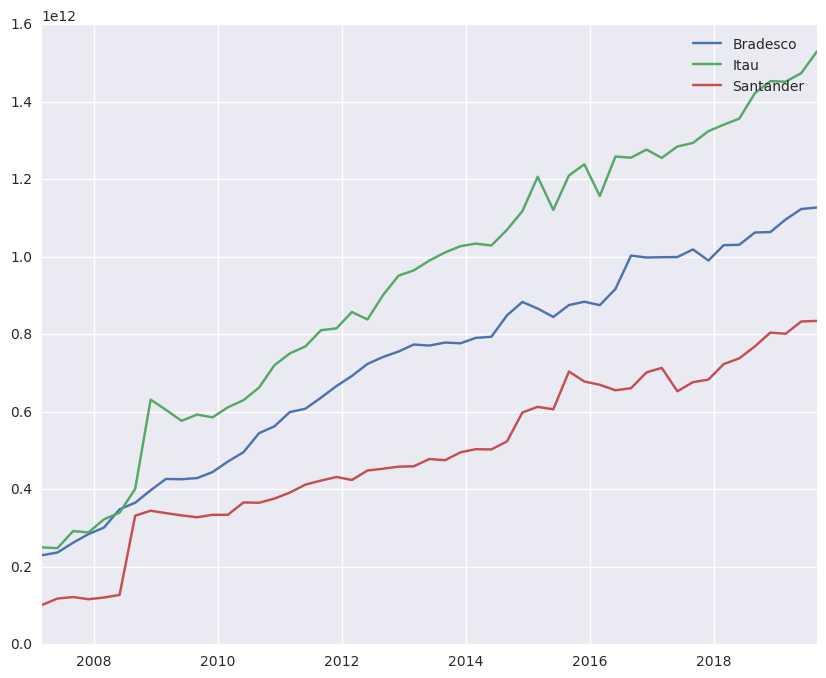

In [14]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.plot(bradesco['data'], bradesco['ativo_total'], label='Bradesco')
plt.plot(itau['data'], itau['ativo_total'], label='Itau')
plt.plot(santander['data'], santander['ativo_total'], label='Santander')

plt.legend()
plt.show()

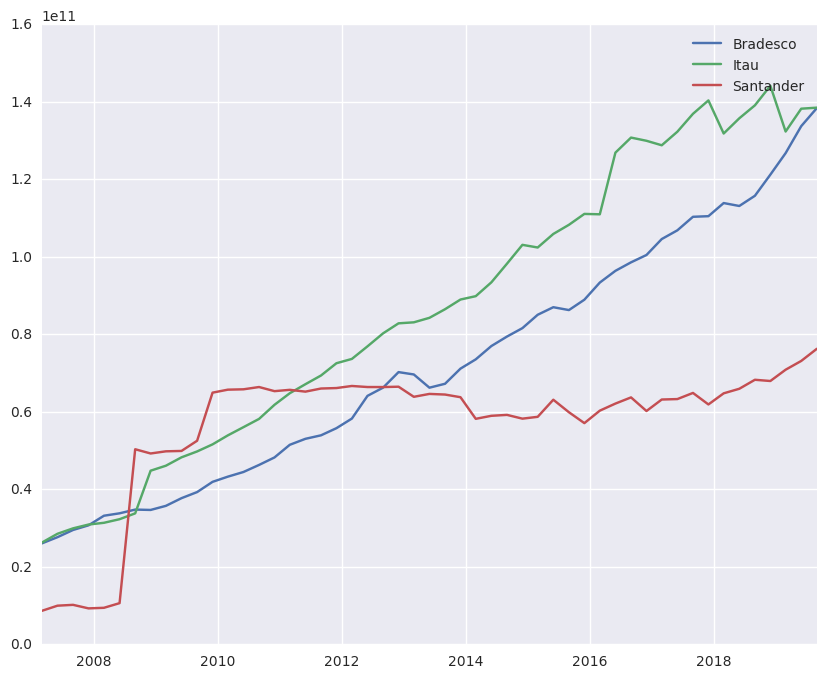

In [15]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.plot(bradesco['data'], bradesco['patr_liquido'], label='Bradesco')
plt.plot(itau['data'], itau['patr_liquido'], label='Itau')
plt.plot(santander['data'], santander['patr_liquido'], label='Santander')

plt.legend()
plt.show()

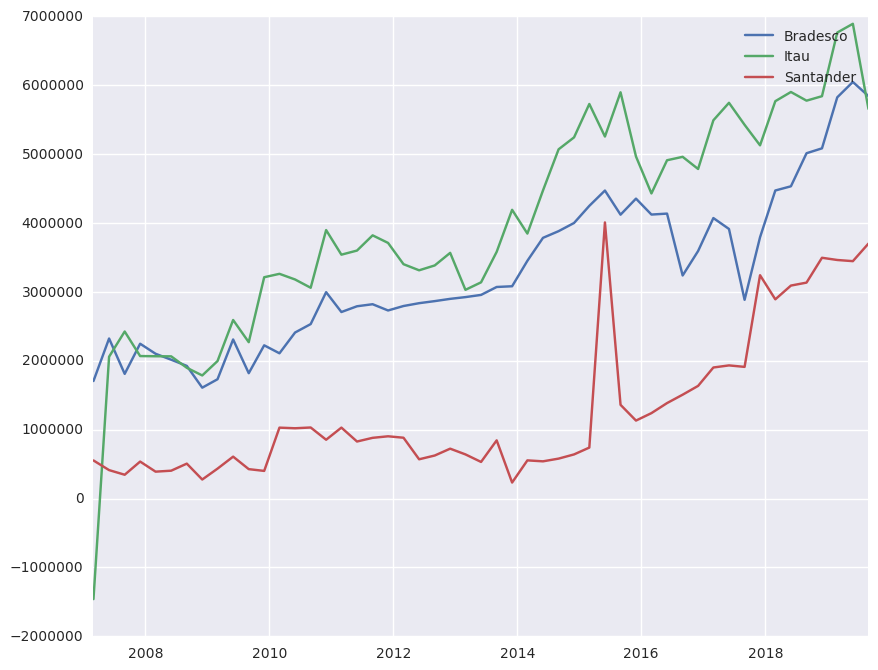

In [16]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.plot(bradesco['data'], bradesco['lucro_liquido_corrigido'], label='Bradesco')
plt.plot(itau['data'], itau['lucro_liquido_corrigido'], label='Itau')
plt.plot(santander['data'], santander['lucro_liquido_corrigido'], label='Santander')

plt.legend()
plt.show()

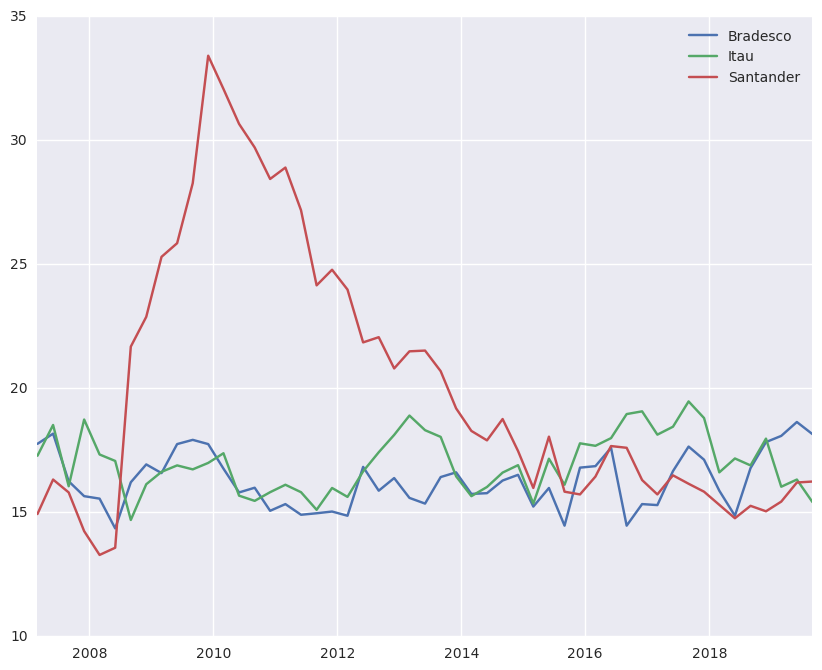

In [17]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.plot(bradesco['data'], bradesco['basileia'], label='Bradesco')
plt.plot(itau['data'], itau['basileia'], label='Itau')
plt.plot(santander['data'], santander['basileia'], label='Santander')

plt.legend()
plt.show()

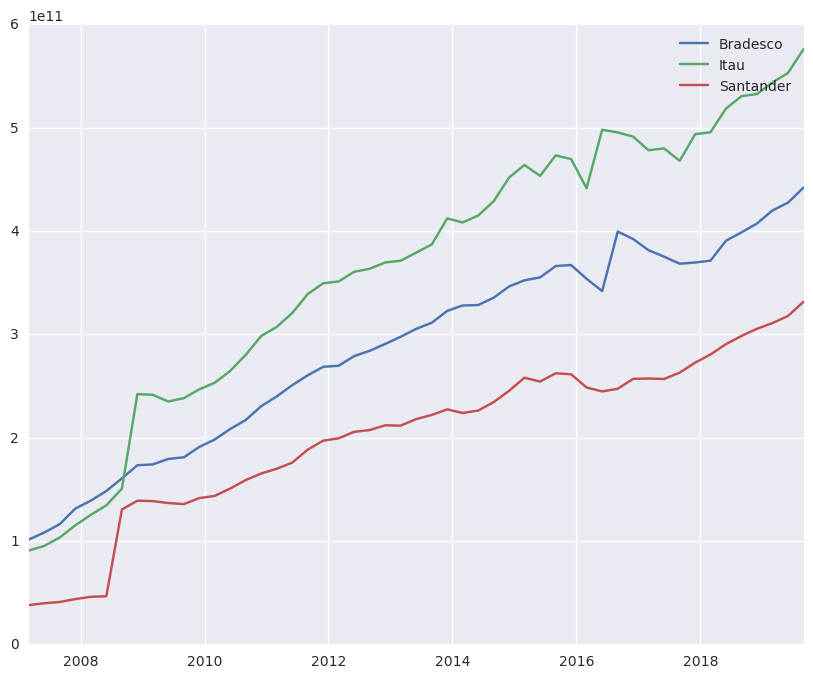

In [18]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.plot(bradesco['data'], bradesco['cart_cred'], label='Bradesco')
plt.plot(itau['data'], itau['cart_cred'], label='Itau')
plt.plot(santander['data'], santander['cart_cred'], label='Santander')

plt.legend()
plt.show()